In [9]:
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import LeakyReLU, BatchNormalization
from keras.initializations import orthogonal
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import SGD
from keras.utils import np_utils
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
batch_size = 32
num_epochs = 200
num_classes = 10
data_augmentation = True

In [42]:
img_rows, img_cols = 32, 32
img_channels = 3

(X_train, y_train), (X_test, y_test) = cifar10.load_data()
print 'X_train.shape: ', X_train.shape

X_train.shape:  (50000, 32, 32, 3)


In [43]:
X_train_indices = np.arange(X_train.shape[0])
X_test_indices = np.arange(X_test.shape[0])
X_train_indices = np.random.choice(X_train_indices, size=10000, replace=False)
X_test_indices = np.random.choice(X_test_indices, size=1000, replace=False)

X_train = X_train[X_train_indices]
X_test = X_test[X_test_indices]
y_train = y_train[X_train_indices]
y_test = y_test[X_test_indices]

print 'X_train.shape: ', X_train.shape
print 'X_test.shape: ', X_test.shape

print 'y_train.shape: ', y_train.shape
print 'y_test.shape: ', y_test.shape

X_train.shape:  (10000, 32, 32, 3)
X_test.shape:  (1000, 32, 32, 3)
y_train.shape:  (10000, 1)
y_test.shape:  (1000, 1)


In [44]:
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

In [23]:
model = Sequential()
model.add(Convolution2D(32, 3, 3, border_mode = 'same', 
                        input_shape=X_train.shape[1:],
                        init='orthogonal'))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Convolution2D(32, 3, 3, init='orthogonal'))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Convolution2D(64, 3, 3, border_mode='same', 
                        init='orthogonal'))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Convolution2D(64, 3, 3,
                        init='orthogonal'))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512, init='glorot_normal'))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.2))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [24]:
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss = 'categorical_crossentropy', optimizer=sgd,
             metrics=['accuracy', 'fbeta_score'])

In [45]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

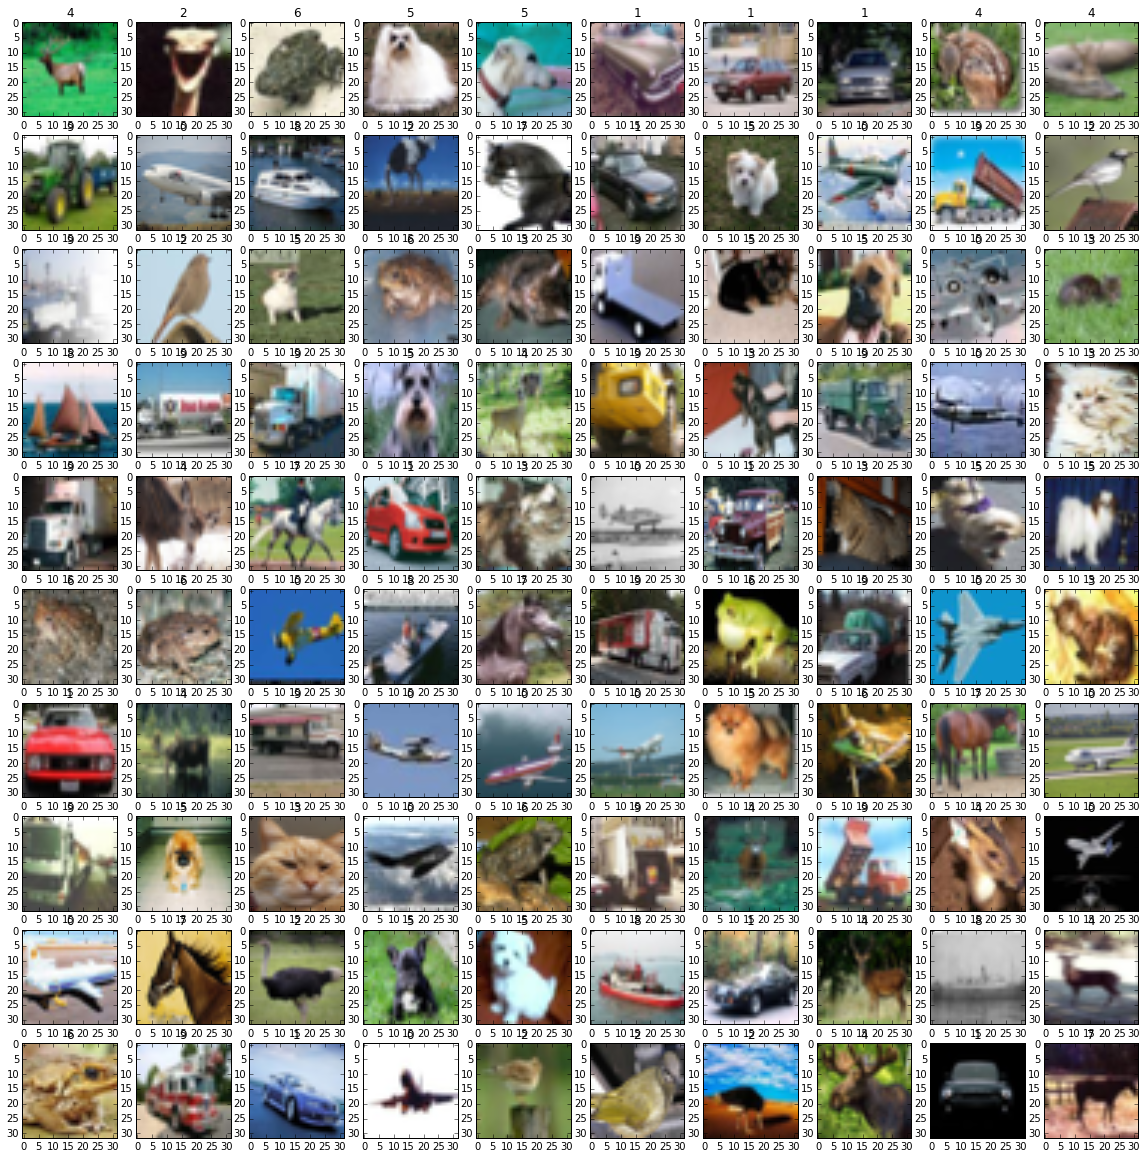

In [35]:
fig, axes = plt.subplots(10, 10, figsize=(20,20))
idx = 0
for i in range(10):
    for j in range(10):
        axes[i][j].imshow(X_train[idx])
        axes[i][j].set_title(np.argmax(y_train[idx]))
        idx+=1

In [37]:
shape = X_train.shape
X_train = X_train.transpose(0, 3, 1, 2).reshape(-1, shape[3], shape[1], shape[2])
X_test = X_test.transpose(0, 3, 1, 2).reshape(-1, shape[3], shape[1], shape[2])

In [46]:
print 'X_train.shape: ', X_train.shape
print 'X_test.shape: ', X_test.shape

print 'y_train.shape: ', y_train.shape
print 'y_test.shape: ', y_test.shape

X_train.shape:  (10000, 32, 32, 3)
X_test.shape:  (1000, 32, 32, 3)
y_train.shape:  (10000, 10)
y_test.shape:  (1000, 10)


In [58]:
from keras.callbacks import ModelCheckpoint, History, EarlyStopping
checkpoint = ModelCheckpoint("weights.{epoch:02d}-{val_loss:.2f}.hdf5", monitor='val_loss', 
                             verbose=1, save_best_only=True, save_weights_only=False, mode='max')
history = History()
early_stopping = EarlyStopping(monitor='val_loss', patience=25, verbose=1, mode='max')
callbacks = [checkpoint, history, early_stopping]

In [48]:
if not data_augmentation:
    print 'Not using data= augmentation.'
    model.fit(X_train, y_train, batch_size=batch_size, 
              nb_epoch = num_epochs, 
              validation_data = (X_test, y_test),
              shuffle=True)
else:
    print 'Using real-time data augmentation.'
    datagen = ImageDataGenerator(
        featurewise_center = False,
        samplewise_center = False,
        featurewise_std_normalization = False,
        samplewise_std_normalization = False,
        zca_whitening = False,
        rotation_range = 0,
        width_shift_range = 0.1,
        height_shift_range = 0.1,
        horizontal_flip = True,
        vertical_flip = False)
    
    datagen.fit(X_train)
    
    model.fit_generator(
        datagen.flow(X_train, y_train, batch_size=batch_size),
        samples_per_epoch = X_train.shape[0],
        nb_epoch = num_epochs,
        callbacks = callbacks,
        validation_data = (X_test, y_test))

Using real-time data augmentation.
Epoch 1/200
10000/10000 [==============================] - 167s - loss: 1.9425 - acc: 0.3277 - fbeta_score: nan - val_loss: 1.7397 - val_acc: 0.3810 - val_fbeta_score: nan
Epoch 2/200
10000/10000 [==============================] - 150s - loss: 1.6199 - acc: 0.4283 - fbeta_score: 0.3498 - val_loss: 1.5893 - val_acc: 0.4480 - val_fbeta_score: 0.3765
Epoch 3/200
10000/10000 [==============================] - 153s - loss: 1.5139 - acc: 0.4578 - fbeta_score: 0.4014 - val_loss: 1.3883 - val_acc: 0.4940 - val_fbeta_score: 0.4519
Epoch 4/200
10000/10000 [==============================] - 176s - loss: 1.3978 - acc: 0.5107 - fbeta_score: 0.4630 - val_loss: 1.8080 - val_acc: 0.4040 - val_fbeta_score: 0.3573
Epoch 5/200
10000/10000 [==============================] - 173s - loss: 1.3140 - acc: 0.5316 - fbeta_score: 0.4959 - val_loss: 1.1931 - val_acc: 0.5740 - val_fbeta_score: 0.5313
Epoch 6/200
10000/10000 [==============================] - 138s - loss: 1.2386 - 

ERROR: Internal Python error in the inspect module.
Below is the traceback from this internal error.



  File "/usr/lib/python2.7/inspect.py", line 1009, in getframeinfo
    filename = getsourcefile(frame) or getfile(frame)
  File "/usr/lib/python2.7/inspect.py", line 454, in getsourcefile
    if hasattr(getmodule(object, filename), '__loader__'):
  File "/usr/lib/python2.7/inspect.py", line 490, in getmodule
    for modname, module in sys.modules.items():
KeyboardInterrupt



Unfortunately, your original traceback can not be constructed.



TypeError: 'NoneType' object is not iterable

In [53]:
model.save('simple.001.model')